In [52]:
import os
import sys

In [53]:
#sys.path.insert(0, '/Users/marusy/Programming/another-fem-framework/')
sys.path.insert(0, '/home/lshtanko/Programming/another-fem-framework/')
#sys.path.insert(0, '/Users/leonshting/Programming/Schlumberger/fem-framework/')

In [54]:
import numpy as np
from interpolant.cell_to_points import Cell2PointsConverter
from interpolant.strict import StrictSolve
from interpolant.opt import OptSolve
from common.helpers import *
from interpolant.helpers import *
from matplotlib import pyplot as plt
%matplotlib inline

In [55]:
np.set_printoptions(linewidth=500, precision=5)

In [56]:
c2p = Cell2PointsConverter(orders=[[5],[5,5]])

In [57]:
strict_solve = StrictSolve(points=c2p.get_points(), weights=c2p.get_diag_weights(), verbose=True)

In [58]:
strict_solve.fit_strict(max_power=strict_solve.get_max_pow(unrisky=False), method='sympy')

Number of equations: 51
Number of degrees of freedom: 66
Strictly stitched_power: 2
Start solving strict part
End solving strict part
NullspaceRank: 15


In [59]:
interps = strict_solve.get_interpolants()
wgths = strict_solve.get_weight_matrices()

In [60]:
opt_solve = OptSolve(matrices=interps,
                     points=c2p.get_points(),
                     strict_power=strict_solve.get_max_pow(unrisky=False),
                     weights_matrices=wgths,
                     verbose=True
                    )

In [ ]:
opt_solve.fit_opt(constraints=True, tr_fun_option='chebyshev', orders_forwards=2, initial_guess=sol)

In [ ]:
opt_solve.restart_opt(tolerance=1e-3)

In [27]:
I_rl = np.array(opt_solve.I_rl_subbed).astype(np.float64)
I_lr = np.array(opt_solve.I_lr_subbed).astype(np.float64)

In [41]:
tr_f = np.vectorize(lambda x: x*(x-1))

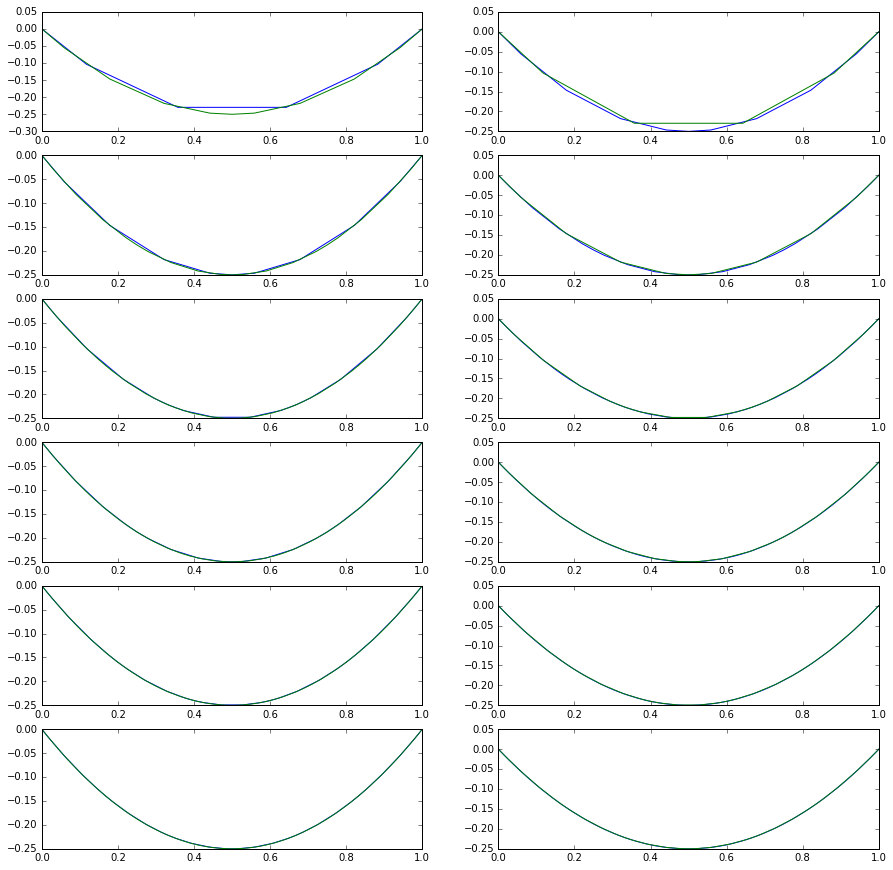

In [42]:
eps_l, eps_r = convergence_test(I_lr=new_int1,
                                I_rl=new_int2,
                                p_l=opt_solve.points[0],
                                p_r=opt_solve.points[1],
                                init_size=(0,1),
                                tr_f=tr_f,
                                weights=[np.array(strict_solve.W_l), np.array(strict_solve.W_r)],
                                div_lim=7)

In [ ]:
explosion_test(I_lr=I_lr,
               I_rl=I_rl,
               p_l=opt_solve.points[0],
               p_r=opt_solve.points[1],
               tr_f=tr_f,
               reps=3)

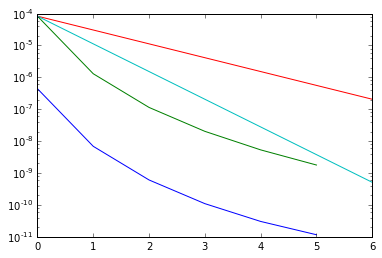

In [34]:
plt.semilogy(range(len(eps_l)), eps_l)
plt.semilogy(range(len(eps_r)), eps_r)
plt.semilogy(np.linspace(0, len(eps_r)), float(eps_r[0])*np.exp(-np.linspace(0, len(eps_r))))
plt.semilogy(np.linspace(0, len(eps_r)), float(eps_r[0])*np.exp(-2*np.linspace(0, len(eps_r))))

In [37]:
np.linalg.eigvals(np.dot(new_int1, new_int2))

array([  3.21800e+02 +0.00000e+00j,   6.41556e+00 +0.00000e+00j,   1.03391e+00 +0.00000e+00j,   9.99984e-01 +3.57403e-05j,   9.99984e-01 -3.57403e-05j,   9.99967e-01 +0.00000e+00j,  -1.17150e-14 +0.00000e+00j,   7.03216e-15 +0.00000e+00j,   5.17856e-15 +0.00000e+00j,   8.04423e-16 +0.00000e+00j,  -1.83947e-15 +0.00000e+00j])

In [ ]:
np.linalg.eigvals(np.dot(I_lr, I_rl))

In [29]:
new_int1 = (I_lr + I_lr[::-1,::-1])/2

In [30]:
new_int2 = (I_rl + I_rl[::-1, ::-1])/2

In [ ]:
c2p.get_weights()[0]

In [ ]:
np.dot(I_rl, c2p.get_weights()[1]).sum()

In [38]:
np.dot(np.dot(c2p.get_diag_weights()[1], new_int1), np.linalg.inv(c2p.get_diag_weights()[0])).T

array([[  2.14976e-01,   1.32507e+00,  -3.95039e+00,   1.11397e+01,  -5.11706e+00,  -4.48627e+00,  -5.39358e+00,   9.52604e+00,  -2.27082e+00,   8.35529e-01,  -8.23168e-01],
       [  8.91140e-02,   2.67385e-01,   1.75753e+00,  -3.52298e+00,   1.54638e+00,   1.42626e+00,   1.76143e+00,  -3.04503e+00,   7.22304e-01,  -2.69101e-01,   2.66708e-01],
       [ -5.66649e-03,  -2.49499e-02,  -2.52049e-01,   1.65916e+00,  -1.17454e-01,  -3.73764e-01,  -5.34912e-01,   8.37971e-01,  -1.91997e-01,   1.07579e-01,  -1.03895e-01],
       [ -1.03895e-01,   1.07579e-01,  -1.91997e-01,   8.37971e-01,  -5.34912e-01,  -3.73764e-01,  -1.17454e-01,   1.65916e+00,  -2.52049e-01,  -2.49499e-02,  -5.66649e-03],
       [  2.66708e-01,  -2.69101e-01,   7.22304e-01,  -3.04503e+00,   1.76143e+00,   1.42626e+00,   1.54638e+00,  -3.52298e+00,   1.75753e+00,   2.67385e-01,   8.91140e-02],
       [ -8.23168e-01,   8.35529e-01,  -2.27082e+00,   9.52604e+00,  -5.39358e+00,  -4.48627e+00,  -5.11706e+00,   1.11397e+01,  -

In [40]:
np.dot(np.dot(c2p.get_diag_weights()[1], new_int1), np.linalg.inv(c2p.get_diag_weights()[0])).T - new_int2

array([[ -1.40393e-05,   1.75706e-07,   2.23305e-05,   4.93999e-05,   5.04259e-05,   0.00000e+00,  -2.65223e-05,  -1.46496e-06,  -3.23368e-05,   2.21069e-05,   2.06268e-06],
       [  2.02147e-05,  -1.14665e-06,  -1.81587e-05,  -2.17272e-07,   6.66586e-07,   8.41051e-06,   2.61014e-05,   2.98207e-05,   7.00594e-07,  -2.63947e-06,  -1.52518e-05],
       [ -1.37209e-05,  -2.79158e-06,  -9.71648e-06,   1.73232e-05,  -9.43878e-07,   6.30401e-06,  -1.50425e-06,  -2.81065e-06,   8.71820e-06,   9.46028e-07,   1.73008e-06],
       [  1.73008e-06,   9.46028e-07,   8.71820e-06,  -2.81065e-06,  -1.50425e-06,   6.30401e-06,  -9.43878e-07,   1.73232e-05,  -9.71648e-06,  -2.79158e-06,  -1.37209e-05],
       [ -1.52518e-05,  -2.63947e-06,   7.00594e-07,   2.98207e-05,   2.61014e-05,   8.41051e-06,   6.66586e-07,  -2.17272e-07,  -1.81587e-05,  -1.14665e-06,   2.02147e-05],
       [  2.06268e-06,   2.21069e-05,  -3.23368e-05,  -1.46496e-06,  -2.65223e-05,   0.00000e+00,   5.04259e-05,   4.93999e-05,   

In [ ]:
new_int2= np.array([[ 0.47913998,  0.6452334 , -0.21919967,  0.02834773,  0.39265603,
        -0.39775608,  0.07157862],
       [ 0.03097077,  0.37368352,  0.51547025,  0.09433045, -0.05016152,
         0.07682102, -0.04111448],
       [-0.04111448,  0.07682102, -0.05016152,  0.09433045,  0.51547025,
         0.37368352,  0.03097077],
       [ 0.07157862, -0.39775608,  0.39265603,  0.02834773, -0.21919967,
         0.6452334 ,  0.47913998]])

In [ ]:
new_int1 = np.array([[ 0.95827995,  0.30970766, -0.41114484,  0.14315723],
       [ 0.25809336,  0.74736704,  0.15364203, -0.15910243],
       [-0.08767987,  1.03094049, -0.10032303,  0.15706241],
       [ 0.02834773,  0.47165227,  0.47165227,  0.02834773],
       [ 0.15706241, -0.10032303,  1.03094049, -0.08767987],
       [-0.15910243,  0.15364203,  0.74736704,  0.25809336],
       [ 0.14315723, -0.41114484,  0.30970766,  0.95827995]])

In [35]:
new_int1

array([[ 0.42995,  1.01182, -0.09432, -1.72941,  3.02827, -1.64634],
       [ 0.46681,  0.53477, -0.07315,  0.31543, -0.5382 ,  0.29435],
       [-0.94928,  2.39766, -0.5041 , -0.38399,  0.98538, -0.54568],
       [ 2.67688, -4.80613,  3.31832,  1.67594, -4.1541 ,  2.28912],
       [-1.80269,  3.09275, -0.34438, -1.5684 ,  3.52285, -1.90011],
       [-4.48627,  8.09704, -3.11079, -3.11079,  8.09704, -4.48627],
       [-1.90011,  3.52285, -1.5684 , -0.34438,  3.09275, -1.80269],
       [ 2.28912, -4.1541 ,  1.67594,  3.31832, -4.80613,  2.67688],
       [-0.54568,  0.98538, -0.38399, -0.5041 ,  2.39766, -0.94928],
       [ 0.29435, -0.5382 ,  0.31543, -0.07315,  0.53477,  0.46681],
       [-1.64634,  3.02827, -1.72941, -0.09432,  1.01182,  0.42995]])

In [36]:
new_int2

array([[  2.14990e-01,   1.32507e+00,  -3.95041e+00,   1.11396e+01,  -5.11711e+00,  -4.48627e+00,  -5.39356e+00,   9.52604e+00,  -2.27078e+00,   8.35507e-01,  -8.23170e-01],
       [  8.90938e-02,   2.67386e-01,   1.75755e+00,  -3.52298e+00,   1.54638e+00,   1.42625e+00,   1.76140e+00,  -3.04506e+00,   7.22304e-01,  -2.69099e-01,   2.66723e-01],
       [ -5.65277e-03,  -2.49471e-02,  -2.52040e-01,   1.65914e+00,  -1.17453e-01,  -3.73770e-01,  -5.34910e-01,   8.37973e-01,  -1.92006e-01,   1.07578e-01,  -1.03897e-01],
       [ -1.03897e-01,   1.07578e-01,  -1.92006e-01,   8.37973e-01,  -5.34910e-01,  -3.73770e-01,  -1.17453e-01,   1.65914e+00,  -2.52040e-01,  -2.49471e-02,  -5.65277e-03],
       [  2.66723e-01,  -2.69099e-01,   7.22304e-01,  -3.04506e+00,   1.76140e+00,   1.42625e+00,   1.54638e+00,  -3.52298e+00,   1.75755e+00,   2.67386e-01,   8.90938e-02],
       [ -8.23170e-01,   8.35507e-01,  -2.27078e+00,   9.52604e+00,  -5.39356e+00,  -4.48627e+00,  -5.11711e+00,   1.11396e+01,  -

In [ ]:
new_int1 = np.array([[ 1.   ,  0.   ,  0.   ],
       [ 0.375,  0.75 , -0.125],
       [ 0.   ,  1.   ,  0.   ],
       [-0.125,  0.75 ,  0.375],
       [ 0.   ,  0.   ,  1.   ]])



In [ ]:
new_int2 = np.dot(np.dot(c2p.get_diag_weights()[1], new_int1), np.linalg.inv(c2p.get_diag_weights()[0])).T

In [ ]:
new_int1

In [ ]:
new_int2

In [ ]:
new_int1 = normalize((new_int1 + new_int2.T)/2)

In [ ]:
def normalize(v):
    norm=np.linalg.norm(v, ord=1, axis=-1)
    return (v.T/norm).T

In [15]:
from common.polynom_factory import polynom_factory

def get_href_constrain_matrix(order, inversed=False, distribution='uniform'):
    glob_func_on_loc_mesh = np.zeros((order+1, order+1))
    funcs_prim, glob_grid = polynom_factory(dim=1, order=order,size=(0,2), distribution=distribution)
    funcs, local_grid = polynom_factory(dim=1, order=order,size=(0,1), distribution=distribution)
    for num1, i in enumerate(local_grid):
        for num2, prim_f in enumerate(funcs_prim):
            glob_func_on_loc_mesh[num1, num2] = prim_f.subs({'x_1':i[0]})
    if(inversed):
        return np.linalg.inv(glob_func_on_loc_mesh)
    else:
        return glob_func_on_loc_mesh

In [50]:
a = get_href_constrain_matrix(distribution='globatto', order=5)
b = np.vstack((a, a[::-1,::-1][1:]))

In [ ]:
a[::-1, ::-1][1:]

In [ ]:
a[1:][::-1, ::-1]

In [51]:
b

array([[ 1.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.33355,  0.79475, -0.18926,  0.0968 , -0.05667,  0.02081],
       [-0.12322,  0.85694,  0.35547, -0.13692,  0.07454, -0.02681],
       [-0.0378 ,  0.14197,  0.97121, -0.10905,  0.05156, -0.01789],
       [ 0.05663, -0.18388,  0.85943,  0.35802, -0.13493,  0.04472],
       [ 0.0625 , -0.19465,  0.63215,  0.63215, -0.19465,  0.0625 ],
       [ 0.04472, -0.13493,  0.35802,  0.85943, -0.18388,  0.05663],
       [-0.01789,  0.05156, -0.10905,  0.97121,  0.14197, -0.0378 ],
       [-0.02681,  0.07454, -0.13692,  0.35547,  0.85694, -0.12322],
       [ 0.02081, -0.05667,  0.0968 , -0.18926,  0.79475,  0.33355],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  1.     ]])

In [17]:
a

array([[ 1.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.33355,  0.79475, -0.18926,  0.0968 , -0.05667,  0.02081],
       [-0.12322,  0.85694,  0.35547, -0.13692,  0.07454, -0.02681],
       [-0.0378 ,  0.14197,  0.97121, -0.10905,  0.05156, -0.01789],
       [ 0.05663, -0.18388,  0.85943,  0.35802, -0.13493,  0.04472],
       [ 0.0625 , -0.19465,  0.63215,  0.63215, -0.19465,  0.0625 ]])

In [19]:
import sympy

In [ ]:
opt_solve.I_lr.shape

In [ ]:
opt_solve.I_rl.shape

In [62]:
b.shape

(11, 6)

In [61]:
eq_matrix = opt_solve.I_lr - sympy.Matrix(b)

In [63]:
eqs_list = []
for i,j in itertools.product(*[range(i) for i in eq_matrix.shape]):
    eqs_list.append(eq_matrix[i,j])

In [64]:
A,b = sympy.linear_eq_to_matrix(eqs_list, *eq_matrix.free_symbols)

In [65]:
A_n = np.array(A)
b_n = np.array(b)

In [66]:
A_n.shape

(66, 15)

In [67]:
b_n.shape

(66, 1)

In [68]:
sol = np.linalg.lstsq(a=A_n, b=b_n)[0]

In [ ]:
subbed = opt_solve.I_lr.subs({i:j for i,j in zip(opt_solve.I_lr.free_symbols, sol)}) 

In [ ]:
subbed

In [ ]:
log = np.linalg.lstsq(a=A_n, b=b_n)

In [ ]:
log

In [69]:
sol

array([[ 4.16545],
       [-1.05108],
       [ 2.30449],
       [ 2.87882],
       [ 0.15891],
       [ 1.10284],
       [ 1.87389],
       [-2.62579],
       [ 1.53705],
       [ 0.54704],
       [-0.29057],
       [-0.06506],
       [ 0.22514],
       [-4.67227],
       [-1.15515]])

In [45]:
a = [8,7,6,5,4,3,2]

In [46]:
b = "1 2 3 4 5 6 7 8 9".split(" ")

In [47]:
c = [b[i] for i in a]

In [48]:
c

['9', '8', '7', '6', '5', '4', '3']

In [49]:
b

['1', '2', '3', '4', '5', '6', '7', '8', '9']